# Step 1: Setup & Libraries

In [ ]:
# Install necessary libraries
!pip install pandas scikit-learn sentence-transformers faiss-cpu --quiet

import pandas as pd
import numpy as np
import sqlite3
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 15.0 MB/s eta 0:00:00


# Step 2: Load Data

In [ ]:
# Upload your CSVs via Colab interface or mount drive
customer_df = pd.read_csv("/content/customer_data_collection.csv")
product_df = pd.read_csv("/content/product_recommendation_data.csv")

# Drop unnamed columns
customer_df = customer_df.loc[:, ~customer_df.columns.str.contains('^Unnamed')]
product_df = product_df.loc[:, ~product_df.columns.str.contains('^Unnamed')]

customer_df.head(), product_df.head()

(  Customer_ID  Age  Gender   Location                 Browsing_History  \
 0       C1000   28  Female    Chennai             ['Books', 'Fashion']   
 1       C1001   27    Male      Delhi  ['Books', 'Fitness', 'Fashion']   
 2       C1002   34   Other    Chennai                  ['Electronics']   
 3       C1003   23    Male  Bangalore                   ['Home Decor']   
 4       C1004   24   Other    Kolkata        ['Fashion', 'Home Decor']   
 
                                Purchase_History    Customer_Segment  \
 0                        ['Biography', 'Jeans']         New Visitor   
 1  ['Biography', 'Resistance Bands', 'T-shirt']  Occasional Shopper   
 2                                ['Smartphone']  Occasional Shopper   
 3                                  ['Wall Art']      Frequent Buyer   
 4                             ['Shoes', 'Lamp']      Frequent Buyer   
 
    Avg_Order_Value Holiday  Season  
 0          4806.99      No  Winter  
 1           795.03     Yes  Autumn  


# Step 3: SQLite Memory DB

In [3]:
# Create SQLite DB for long-term memory
conn = sqlite3.connect("memory.db")
cursor = conn.cursor()

# Create table
cursor.execute('''
CREATE TABLE IF NOT EXISTS customer_interactions (
    customer_id TEXT,
    recommended_products TEXT
)
''')
conn.commit()

# Function to store interaction
def store_interaction(customer_id, product_ids):
    cursor.execute("INSERT INTO customer_interactions VALUES (?, ?)",
                   (customer_id, json.dumps(product_ids)))
    conn.commit()

# Step 4: Agents Implementation

In [4]:
# Load embedding model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# --- Customer Agent ---
class CustomerAgent:
    def __init__(self, customer_df):
        self.df = customer_df

    def get_profile(self, customer_id):
        return self.df[self.df['Customer_ID'] == customer_id].iloc[0]

# --- Product Agent ---
class ProductAgent:
    def __init__(self, product_df):
        self.df = product_df.copy()
        self.df['embedding'] = self.df['Category'] + " " + self.df['Subcategory'] + " " + self.df['Similar_Product_List'].apply(str)
        self.df['vector'] = embedder.encode(self.df['embedding'].tolist())

    def get_top_similar(self, interests, top_n=5):
        interest_vector = embedder.encode([" ".join(interests)])
        similarities = cosine_similarity([interest_vector], list(self.df['vector']))[0]
        top_indices = similarities.argsort()[-top_n:][::-1]
        return self.df.iloc[top_indices]

# --- Recommender Agent ---
class RecommenderAgent:
    def __init__(self, customer_agent, product_agent):
        self.customer_agent = customer_agent
        self.product_agent = product_agent

    def recommend(self, customer_id):
        profile = self.customer_agent.get_profile(customer_id)
        interests = eval(profile['Browsing_History']) + eval(profile['Purchase_History'])
        products = self.product_agent.get_top_similar(interests)
        store_interaction(customer_id, products['Product_ID'].tolist())
        return products[['Product_ID', 'Category', 'Subcategory', 'Price', 'Product_Rating']]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Step 5: Multi-Agent Controller

In [5]:
class InteractionAgent:
    def __init__(self, recommender):
        self.recommender = recommender

    def run(self, customer_id):
        print(f"\n🔍 Generating recommendations for: {customer_id}")
        recommendations = self.recommender.recommend(customer_id)
        print(recommendations.to_string(index=False))
        return recommendations

# Step 6: Run App

In [6]:
customer_agent = CustomerAgent(customer_df)
product_agent = ProductAgent(product_df)
recommender_agent = RecommenderAgent(customer_agent, product_agent)
interaction_agent = InteractionAgent(recommender_agent)

# Try any customer_id from the dataset, e.g., "C1001"
interaction_agent.run("C1001")

ValueError: Expected a 1D array, got an array with shape (10000, 384)

In [7]:
class ProductAgent:
    def __init__(self, product_df):
        self.df = product_df.copy()
        self.df['embedding'] = self.df['Category'] + " " + self.df['Subcategory'] + " " + self.df['Similar_Product_List'].apply(str)
        # The line below is updated to store embeddings as a list within the 'vector' column
        self.df['vector'] = self.df['embedding'].apply(lambda x: embedder.encode(x))

    def get_top_similar(self, interests, top_n=5):
        interest_vector = embedder.encode([" ".join(interests)])
        # Update this line to access the vectors correctly
        similarities = cosine_similarity([interest_vector], self.df['vector'].tolist())[0]
        top_indices = similarities.argsort()[-top_n:][::-1]
        return self.df.iloc[top_indices]

In [8]:
# --- Product Agent ---
class ProductAgent:
    def __init__(self, product_df):
        self.df = product_df.copy()
        self.df['embedding'] = self.df['Category'] + " " + self.df['Subcategory'] + " " + self.df['Similar_Product_List'].astype(str)

        # Compute embeddings
        raw_embeddings = embedder.encode(self.df['embedding'].tolist())

        # Store vectors as a list of numpy arrays
        self.df['vector'] = [vec for vec in raw_embeddings]

    def get_top_similar(self, interests, top_n=5):
        interest_vector = embedder.encode([" ".join(interests)])[0].reshape(1, -1)
        all_vectors = np.stack(self.df['vector'].values)
        similarities = cosine_similarity(interest_vector, all_vectors)[0]
        top_indices = similarities.argsort()[-top_n:][::-1]
        return self.df.iloc[top_indices]

In [11]:
customer_df['Customer_ID'].head(10)

,Customer_ID
0,C1000
1,C1001
2,C1002
3,C1003
4,C1004
5,C1005
6,C1006
7,C1007
8,C1008
9,C1009


In [9]:
# Initialize agents again with the fixed product agent
customer_agent = CustomerAgent(customer_df)
product_agent = ProductAgent(product_df)
recommender_agent = RecommenderAgent(customer_agent, product_agent)
interaction_agent = InteractionAgent(recommender_agent)

# Try with a real Customer ID from your dataset
# Replace "C1001" with an actual ID from your `customer_df`
interaction_agent.run("C1001")


🔍 Generating recommendations for: C1001
Product_ID Category      Subcategory  Price  Product_Rating
     P6603  Fitness Resistance Bands   4750             3.0
     P7351  Fitness Resistance Bands   4703             2.7
     P4746  Fitness Resistance Bands   4437             4.5
     P4420  Fitness Resistance Bands   1183             2.5
    P10016  Fitness Resistance Bands   4243             4.1


,Product_ID,Category,Subcategory,Price,Product_Rating
4603,P6603,Fitness,Resistance Bands,4750,3.0
5351,P7351,Fitness,Resistance Bands,4703,2.7
2746,P4746,Fitness,Resistance Bands,4437,4.5
2420,P4420,Fitness,Resistance Bands,1183,2.5
8016,P10016,Fitness,Resistance Bands,4243,4.1


# Step 7: View Stored Recommendations from SQLite

In [13]:
def view_memory():
    cursor.execute("SELECT * FROM customer_interactions")
    rows = cursor.fetchall()
    for row in rows:
        customer_id, products = row
        print(f"🧠 Customer {customer_id} ➤ Recommended: {json.loads(products)}")

view_memory()

🧠 Customer C1001 ➤ Recommended: ['P6603', 'P7351', 'P4746', 'P4420', 'P10016']


# Step 9: Data Visualizations

 9.1. Customer Segment Distribution

<ipython-input-14-045c1af8c28d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customer_df, x='Customer_Segment', palette='coolwarm')


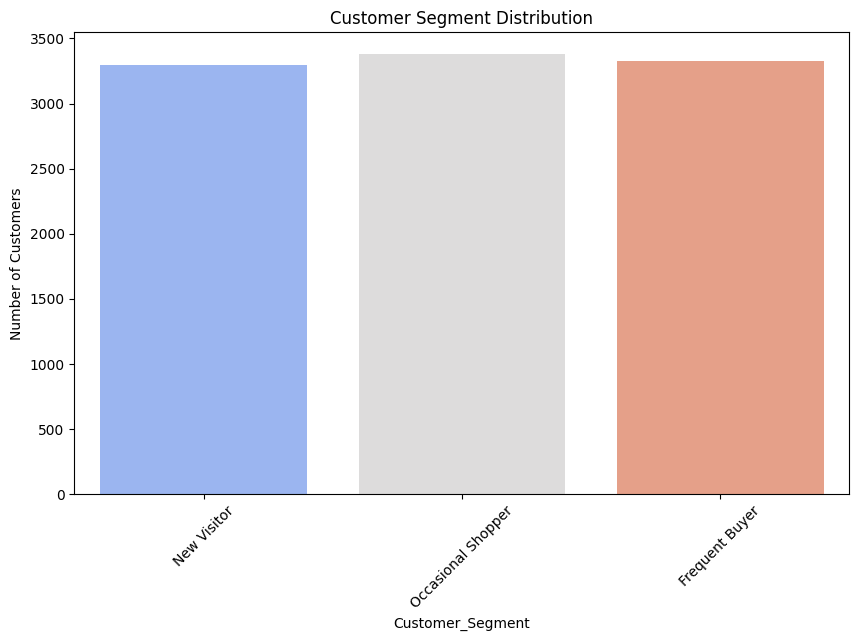

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot customer segmentation
plt.figure(figsize=(10, 6))
sns.countplot(data=customer_df, x='Customer_Segment', palette='coolwarm')
plt.title("Customer Segment Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Customers")
plt.show()

9.2. Top Purchased Products

<ipython-input-16-a6f3f6cadeed>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_purchases.keys()), y=list(top_purchases.values()), palette='viridis')


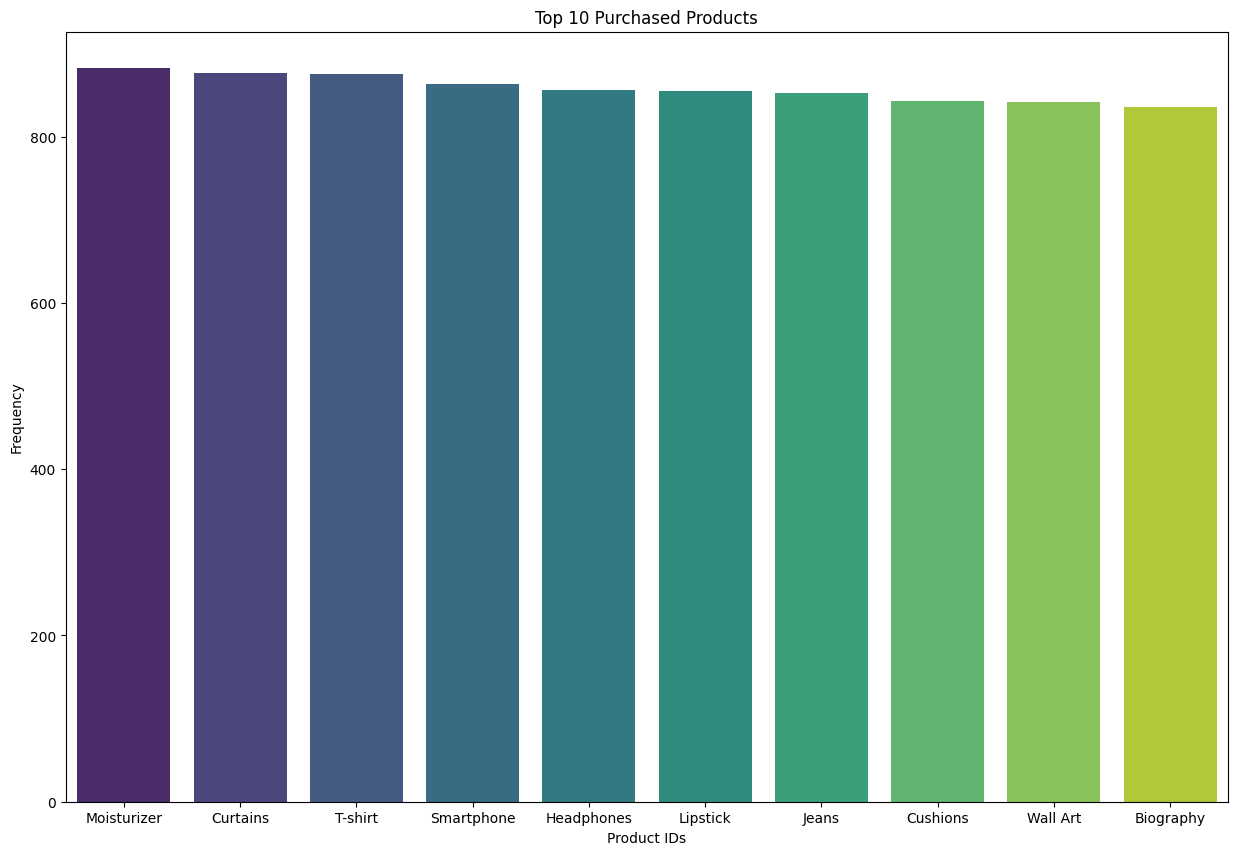

In [16]:
from collections import Counter
import ast

# Flatten all purchases
all_purchases = customer_df['Purchase_History'].apply(ast.literal_eval).sum()
purchase_counts = Counter(all_purchases)
top_purchases = dict(purchase_counts.most_common(10))

plt.figure(figsize=(15, 10))
sns.barplot(x=list(top_purchases.keys()), y=list(top_purchases.values()), palette='viridis')
plt.title("Top 10 Purchased Products")
plt.ylabel("Frequency")
plt.xlabel("Product IDs")
plt.show()

9.3. Product Ratings Distribution

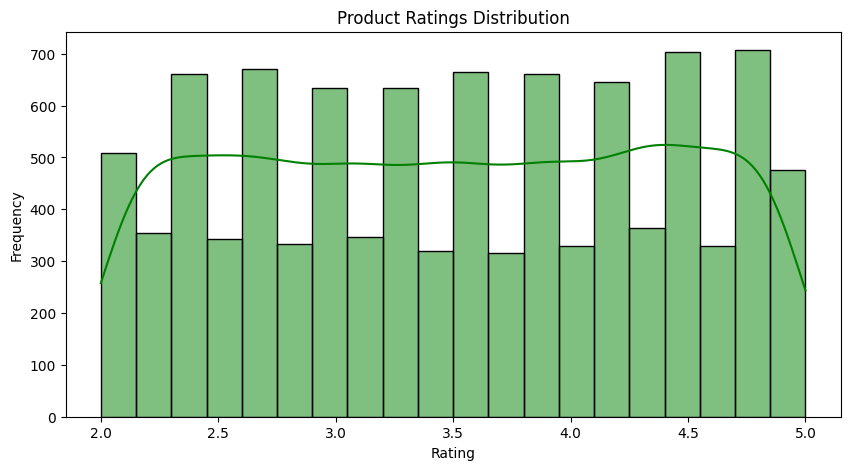

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(product_df['Product_Rating'], bins=20, kde=True, color='green')
plt.title("Product Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

9.4. Memory DB Heatmap – Customer vs Stored Recommendations

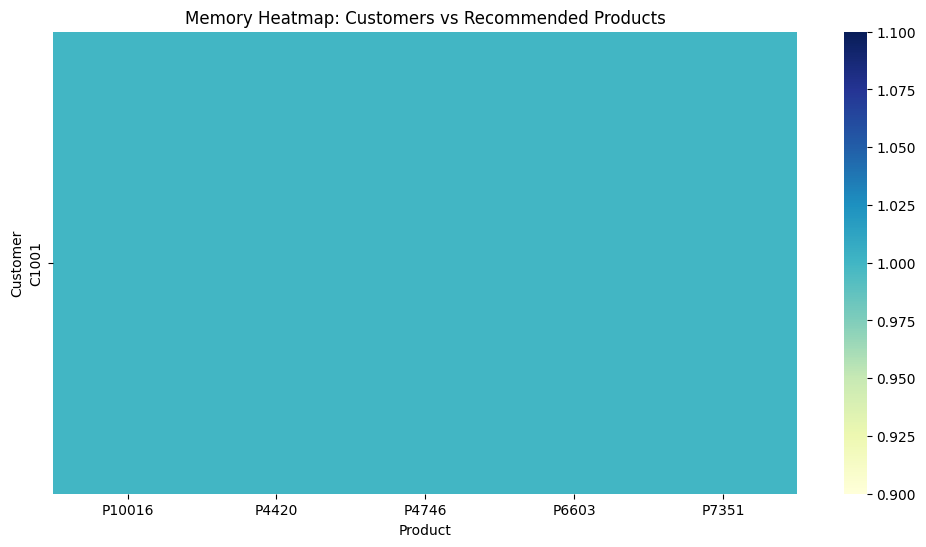

In [18]:
# Extract customer interaction memory
cursor.execute("SELECT * FROM customer_interactions")
rows = cursor.fetchall()

# Prepare a matrix of customer vs product recommendations
memory_matrix = {}

for customer_id, products in rows:
    product_ids = json.loads(products)
    for pid in product_ids:
        memory_matrix[(customer_id, pid)] = 1

# Convert to dataframe
memory_df = pd.DataFrame(memory_matrix.values(),
                         index=pd.MultiIndex.from_tuples(memory_matrix.keys(), names=['Customer', 'Product']),
                         columns=['Recommended'])

pivot_df = memory_df.reset_index().pivot(index='Customer', columns='Product', values='Recommended').fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap='YlGnBu', cbar=True)
plt.title("Memory Heatmap: Customers vs Recommended Products")
plt.show()

# Step 10: Customer Purchase History Analysis

In [19]:
from collections import Counter

# Group purchases by customer ID
customer_purchases = customer_df.groupby('Customer_ID')['Purchase_History'].apply(lambda x: x.str.replace('[', '').str.replace(']', '').str.replace("'", '').str.split(', ').sum()).reset_index()
customer_purchases.columns = ['Customer_ID', 'Products']

# Count product frequencies for each customer
customer_purchases['Product_Counts'] = customer_purchases['Products'].apply(lambda x: Counter(x))

# Example: Display top 5 purchased products for each customer
for index, row in customer_purchases.head().iterrows():
    print(f"Customer {row['Customer_ID']}: Top 5 Purchases - {row['Product_Counts'].most_common(5)}")

Customer C1000: Top 5 Purchases - [('Biography', 1), ('Jeans', 1)]
Customer C10000: Top 5 Purchases - [('Perfume', 1)]
Customer C10001: Top 5 Purchases - [('Treadmill', 1)]
Customer C10002: Top 5 Purchases - [('Lamp', 1)]
Customer C10003: Top 5 Purchases - [('Cushions', 1)]


# Step 11: Product Recommendation Performance Evaluation

In [20]:
def calculate_precision(customer_id, recommendations):
    """Calculates precision for a given customer and recommendations."""
    actual_purchases = customer_df[customer_df['Customer_ID'] == customer_id]['Purchase_History'].values[0]
    actual_purchases = set(actual_purchases.replace('[', '').replace(']', '').replace("'", '').split(', '))
    recommended_products = set(recommendations['Product_ID'].tolist())

    # Calculate precision (relevant recommendations / total recommendations)
    precision = len(actual_purchases.intersection(recommended_products)) / len(recommended_products) if len(recommended_products) > 0 else 0
    return precision

# Example usage
customer_id = "C1001"
recommendations = interaction_agent.run(customer_id)
precision = calculate_precision(customer_id, recommendations)
print(f"Precision for customer {customer_id}: {precision}")


🔍 Generating recommendations for: C1001
Product_ID Category      Subcategory  Price  Product_Rating
     P6603  Fitness Resistance Bands   4750             3.0
     P7351  Fitness Resistance Bands   4703             2.7
     P4746  Fitness Resistance Bands   4437             4.5
     P4420  Fitness Resistance Bands   1183             2.5
    P10016  Fitness Resistance Bands   4243             4.1
Precision for customer C1001: 0.0


# Step 12: Enhance User Interface for Interactive Exploration

In [22]:
import ipywidgets as widgets
from IPython.display import display

# Create input widget for customer ID
customer_id_input = widgets.Text(
    value='C1001',
    placeholder='Enter Customer ID',
    description='Customer ID:',
    disabled=False
)

# Create output widget for recommendations
recommendations_output = widgets.Output()

# Define function to update recommendations
def update_recommendations(change):
    with recommendations_output:
        recommendations_output.clear_output()
        customer_id = change.new
        profile = customer_agent.get_profile(customer_id)  # Get customer profile
        if profile is not None:  # Check if profile exists
            recommendations = interaction_agent.run(customer_id)
            display(recommendations)  # Display recommendations
        else:
            print(f"Customer ID '{customer_id}' not found.")

# Link input widget to update function
customer_id_input.observe(update_recommendations, names='value')

# Display widgets
display(customer_id_input, recommendations_output)

Text(value='C1001', description='Customer ID:', placeholder='Enter Customer ID')

Output()